In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import shapiro
from scipy import stats
from statistics import mean

from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import joblib

In [14]:
# Lectura de df
Opto = pd.read_csv("OptoDF.csv", sep=";", header=0, decimal=',')
df = Opto.drop(['Unnamed: 0','ID'],axis=1)

In [15]:
df.head()

,Patology,Peso.Kg.,Altura.cm.,N.Pie,TContacto.media,TPaso.media,Ritmo.paso.media,Paso.media,Velocidad.media,Aceleracion.media,...,ContactPhase..desviacion,FootFlat.desviacion,FootFlat..desviacion,PropulsivePhase.desviacion,PropulsivePhase..desviacion,LoadResponse.desviacion,LoadResponse..desviacion,PreSwing.desviacion,PreSwing..desviacion,TContactoPerc.desviacion
0,2,55.0,167,38.0,0.941773,0.638732,87.418000,46.466667,0.681500,0.004872,...,5.186452,0.164384,17.266623,0.153145,17.029910,0.072338,5.510019,0.072430,5.504602,5.889253
1,1,71.0,171,41.0,0.550677,0.656128,138.291339,74.661538,1.812835,0.000960,...,4.243606,0.173981,20.118789,0.188847,19.255388,0.016203,1.104976,0.016143,1.298468,4.984607
2,6,77.0,175,42.0,0.694568,0.473460,119.286792,49.608333,0.980094,0.000288,...,4.831077,0.134382,17.017202,0.111317,18.579768,0.063332,3.634810,0.036969,3.187258,4.646422
3,2,85.0,173,43.0,0.527065,0.589490,135.460549,68.486301,1.549231,0.001348,...,2.546563,0.171786,9.691292,0.105450,9.214958,0.017415,1.235209,0.017306,1.375467,12.070837
4,6,88.0,187,45.0,0.842776,0.583479,98.612766,49.666667,0.819149,0.001304,...,4.406907,0.197653,23.029313,0.201266,24.182264,0.043150,3.736075,0.042872,3.873034,3.818948


#### Problema multiclase

In [6]:
# #Procesamiento y limpieza

df = df.drop(df[df['Patology'] == 9].index) #Me cargo la clase "otro"
# # df.loc[(df['Patology'] == 5) | (df['Patology'] == 6), 'Patology'] = 2
df = df.drop(df[(df['Patology'] == 5) | (df['Patology'] == 6)| (df['Patology'] == 2)].index) #Me cargo los Esguinces, Aquiles y Síndromes de Predislocación
# df.loc[df['Patology'] == 8, 'Patology'] = 7 #Unifico los retropies varo y valgo
df = df.drop(df[(df['Patology'] == 7) | (df['Patology'] == 8)].index) #Me cargo la clase retropie que los había metido yo en un principio por salvar algún dato
# # df[(df['Patology'] == 5) | (df['Patology'] == 6)]["Patology"] = 2 #Unifico Esguince, Aquiles y Sind. Predislocación (Porque no hay suficientes datos)
df.loc[df['Patology'] == 1, 'Patology'] = 1 #Fascitis
df.loc[df['Patology'] == 3, 'Patology'] = 2 #Pie Plano
df.loc[df['Patology'] == 4, 'Patology'] = 3 #Pie Cavo
# df.loc[df['Patology'] == 7, 'Patology'] = 4 #Retropie Varo/Valgo




# df['Patology'] = df['Patology'].astype('category')

#### Problema Binario

In [16]:
#------------------------ Creo un problema binario entre Fascitis y otro

df = df.drop(df[(df['Patology'] == 7) | (df['Patology'] == 8)].index) #Me cargo la clase retropie que los había metido yo en un principio por salvar algún dato
df = df.drop(df[df['Patology'] == 9].index) #Me cargo la clase "otro"

df.loc[(df['Patology'] == 5) | (df['Patology'] == 6) | (df['Patology'] == 3) | (df['Patology'] == 4) | (df['Patology'] == 2), 'Patology'] = 0
df['Patology'] = df['Patology'].astype('category')

# 0 -> otro
# 1 -> Fascitis

In [17]:
df['Patology'].value_counts()

Patology
0    209
1     89
Name: count, dtype: int64

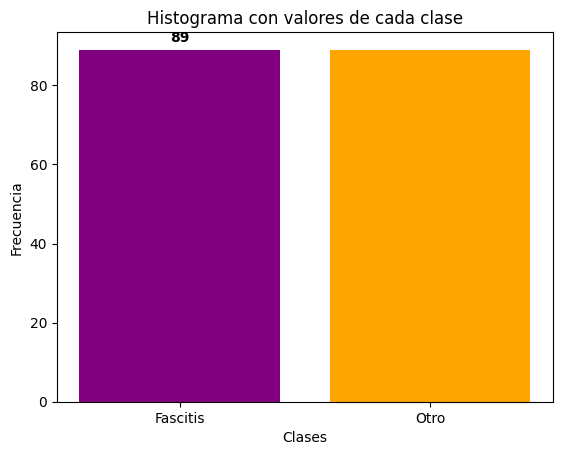

In [21]:
# plt.hist(df['Patology'])
# plt.show()
# df['Patology'].value_counts()

hist, bins = np.histogram(df['Patology'], bins=np.arange(1, 3))  # Adjust bin range if needed
colors = ['purple', 'orange', 'orange', 'red', 'purple', 'yellow', 'pink', 'gray', 'brown']
unique_classes = ['Fascitis', 'Otro']  # Only two classes

# Create the histogram
plt.bar(unique_classes, hist, color=colors)  # Use colors for the first two classes

# Add values above each bar
for i, v in enumerate(hist):
    plt.text(unique_classes[i], v + 2, str(v), ha='center', color='black', fontweight='bold')

plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Histograma con valores de cada clase')


plt.show()

1 -> Fascitis

2 -> Esguince, Aquiles y Sind. Predislocación

3 -> Pie Plano

4 -> Pie Cavo

7 -> Retropie Varo/Valgo


In [22]:
x = df.drop(['Patology'],axis=1)
y = pd.DataFrame(df['Patology'])

In [9]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Index", "Feature"]

for index, feature in enumerate(x.columns.values.tolist()):
    table.add_row([index, feature])
    
print(table)

+-------+--------------------------------+
| Index |            Feature             |
+-------+--------------------------------+
|   0   |            Peso.Kg.            |
|   1   |           Altura.cm.           |
|   2   |             N.Pie              |
|   3   |        TContacto.media         |
|   4   |          TPaso.media           |
|   5   |        Ritmo.paso.media        |
|   6   |           Paso.media           |
|   7   |        Velocidad.media         |
|   8   |       Aceleracion.media        |
|   9   |      Desequilibrio.media       |
|   10  |        Distancia.media         |
|   11  |         Zancada.media          |
|   12  |     StrideTime.Cycle.media     |
|   13  |      SingleSupport.media       |
|   14  |      SingleSupport..media      |
|   15  |    TotalDoubleSupport.media    |
|   16  |   TotalDoubleSupport..media    |
|   17  |         TStance.media          |
|   18  |         TStance..media         |
|   19  |          TSwing.media          |
|   20  |  

### ANÁLISIS UNIVARIANTE

In [23]:
x[['Peso.Kg.','Altura.cm.','N.Pie','TContacto.media','TPaso.media','Zancada.media','TPaso.desviacion','TSwing.desviacion']].describe() 
# sns.histplot(x['Peso.Kg.'],kde=True, color='blue')
# plt.savefig('Peso.png')

,Peso.Kg.,Altura.cm.,N.Pie,TContacto.media,TPaso.media,Zancada.media,TPaso.desviacion,TSwing.desviacion
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,67.484899,164.201342,40.038591,0.848197,0.603592,108.522747,0.089978,0.052616
std,20.778934,17.108283,3.353377,0.181393,0.120916,18.113814,0.075582,0.069581
min,13.000000,39.000000,27.000000,0.338337,0.169388,75.264151,0.013600,0.010259
25%,55.000000,159.000000,38.000000,0.763942,0.550554,96.135665,0.026441,0.019328
50%,67.100000,167.000000,40.000000,0.879480,0.604601,104.997312,0.070417,0.025780
75%,80.750000,175.000000,43.000000,0.960274,0.651878,115.634512,0.136484,0.059394
max,134.000000,198.000000,47.000000,1.441130,1.312833,179.527211,0.410483,0.611347


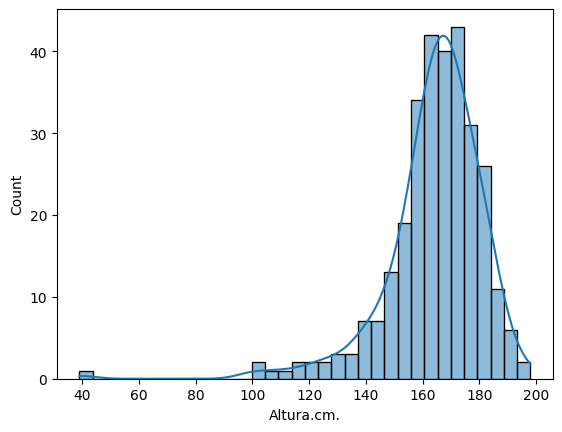

In [24]:
x['Altura.cm.'].describe()
sns.histplot(x['Altura.cm.'],kde=True)
plt.savefig('Altura.cm.')

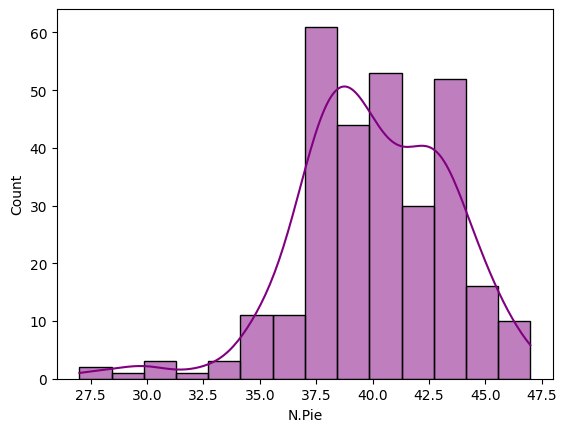

In [27]:
x['N.Pie'].describe()
sns.histplot(x['N.Pie'],kde=True, color='purple')
plt.savefig('N_Pie.png')

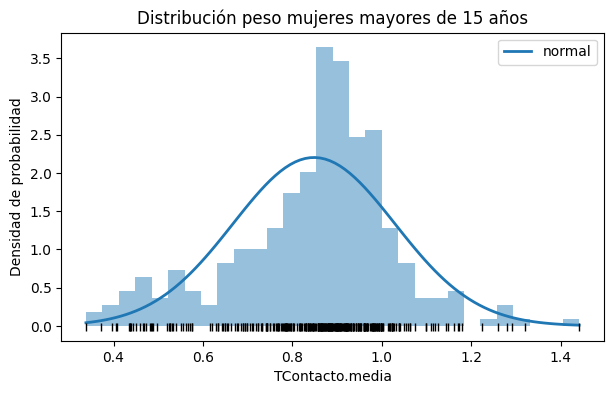

In [26]:
# x['TContacto.media'].describe(), sns.histplot(x['TContacto.media'],kde=True)

# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(x['TContacto.media'])

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(x['TContacto.media']), max(x['TContacto.media']), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=x['TContacto.media'], density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(x['TContacto.media'], np.full_like(x['TContacto.media'], -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución peso mujeres mayores de 15 años')
ax.set_xlabel('TContacto.media')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

plt.savefig('dsitrPeso.png')

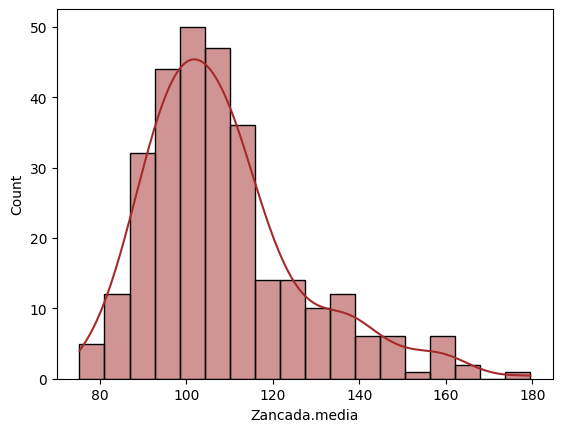

In [28]:
x['Zancada.media'].describe()
sns.histplot(x['Zancada.media'],kde=True, color='brown')
plt.savefig('Zancada.png')

### Resampling

In [29]:
#Primero aplico un oversampling sobre la clase minoritaria y después undersampling sobre la mayoritaria.

# Smote Oversampling
oversample = SMOTE(sampling_strategy=0.7)
X_resampled, y_resampled = oversample.fit_resample(x, y)
y_resampled.value_counts()

Patology
0           209
1           146
Name: count, dtype: int64

In [30]:
# Random Under sampler
undersample = RandomUnderSampler(sampling_strategy=0.8)
X_underresampled, y_underresampled = undersample.fit_resample(X_resampled, y_resampled)
y_underresampled.value_counts()

Patology
0           182
1           146
Name: count, dtype: int64

¿Distribución normal?

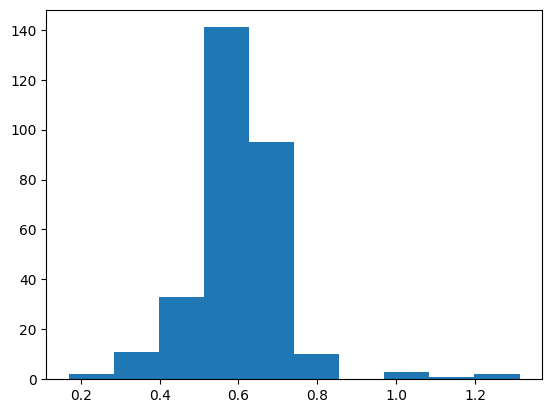

Estadisticos=0.856, p=0.000
La muestra no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)


In [31]:
def normalidad(data):
    #Histograma
    plt.hist(data)
    plt.show()
    
    #Shapiro-Wilk test
    stat, p = shapiro(data)
    print('Estadisticos=%.3f, p=%.3f' % (stat, p))
    # Interpretación
    alpha = 0.05
    if p > alpha:
       print('La muestra parece Gaussiana o Normal (no se rechaza la hipótesis nula H0)')
    else:
       print('La muestra no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)')

normalidad(x["TPaso.media"])

In [32]:
scaler=StandardScaler()
scaler.fit(x) # calculo la media para poder hacer la transformacion
X_scaled=scaler.transform(x)# Normalizo los datos sin resampling

In [33]:
# Oversampled standarized data
scaler=StandardScaler()
scaler.fit(X_resampled) # calculo la media para poder hacer la transformacion
X_resampled_scaled=scaler.transform(X_resampled)# Ahora si, escalo los datos y los normalizo
joblib.dump(scaler,"scaler.pkl")

['scaler.pkl']

In [34]:
#Usar plotly para graficas interactivas y otros tipos
#Usar svc (gamma y kernel)

LABELS = [0,1]

#creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test, func, *args, **kargs): #*lista de variables, **diccionario de variables
    #C=1.0,penalty='l2',random_state=1,solver="newton-cg"
    clf_base = func(**kargs)
    clf_base.fit(X_train, y_train.values.ravel())
    return clf_base


#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))


### Análisis Multivariante

In [35]:
df['Patology'] = df['Patology'].astype("float64")# df['Patology'] = df['Patology'].astype("float64")

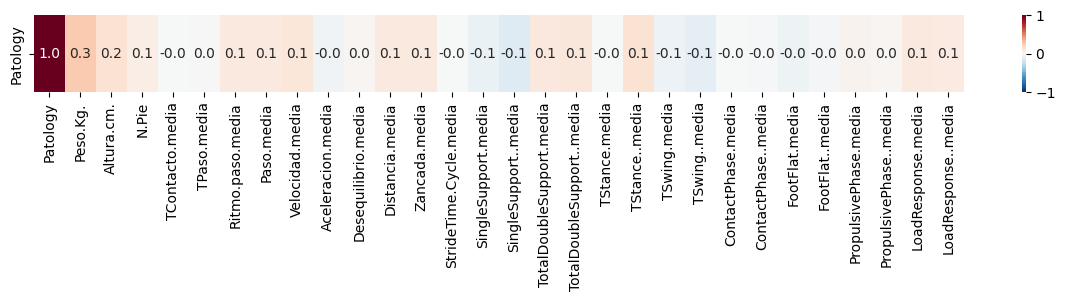

In [36]:
corr_mat = df.corr() #creo la matriz de correlación
corr_class = corr_mat['Patology'].to_frame().T.iloc[:, : 30] #la transpongo y selecciono las 30 primeras variables
# Plot heatmap
plt.figure(figsize=(15, 1))
sns.heatmap(corr_class, annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1)
plt.savefig('Corre1.png')

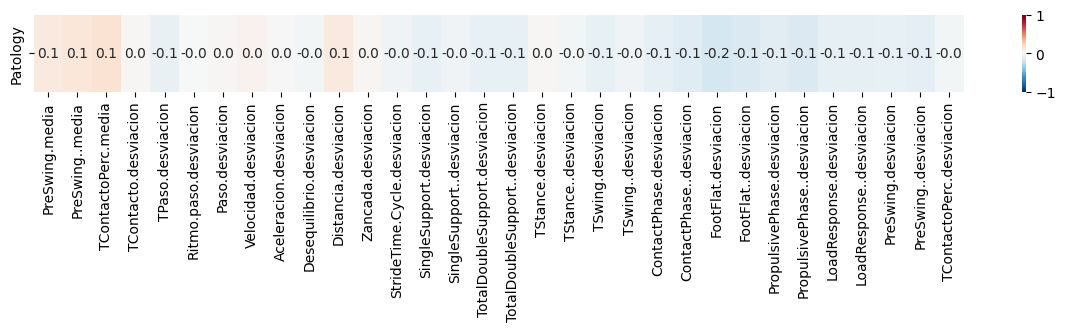

In [37]:
corr_mat = df.corr() #creo la matriz de correlación sobre Patología de las primeras variables
corr_class = corr_mat['Patology'].to_frame().T.iloc[:, -32 :] #la transpongo
# Plot heatmap
plt.figure(figsize=(15, 1))
sns.heatmap(corr_class, annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1)
plt.savefig('Corre2.png')

### Feature Selection

#### PCA

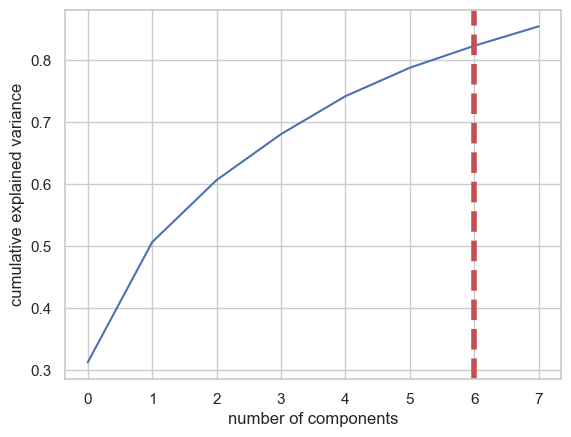

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.312784,0.312784
1,0.506349,0.193565
2,0.606294,0.099945
3,0.680191,0.073897
4,0.741305,0.061114
5,0.787096,0.045791
6,0.822445,0.035349
7,0.853711,0.031266


In [38]:
pca_all = PCA(n_components=8)
pca_transform = pca_all.fit_transform(X_scaled)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6, ymin=0, ymax=1)
display(plt.show())

evr = pca_all.explained_variance_ratio_
cvr = np.cumsum(pca_all.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(15))

In [39]:
print("shape of X_pca", pca_transform.shape)
expl = pca_all.explained_variance_ratio_
print(expl)
print('suma:',sum(expl))
print(expl[0:5])
print('suma de 5:',sum(expl[0:5]))
print('suma de 6:',sum(expl[0:6]))

shape of X_pca (298, 8)
[0.31278438 0.19356492 0.09994471 0.07389745 0.06111393 0.04579073
 0.0353489  0.03126614]
suma: 0.8537111699846439
[0.31278438 0.19356492 0.09994471 0.07389745 0.06111393]
suma de 5: 0.7413053949028433
suma de 6: 0.7870961288040887


Aplico un PCA con 8 componentes, porque es 85% de varianza explicada un valor aceptable y así quitamos todas las variables posibles.

In [40]:
# Scaled pca data
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(298, 8)

In [41]:
# Resampled scaled pca data
pca = PCA(n_components=8)
X_resampled_scaled_pca = pca.fit_transform(X_resampled_scaled)
X_resampled_scaled_pca.shape

(355, 8)

#### Variance Threshold

In [42]:
THR = VarianceThreshold(threshold=12)
THR.fit_transform(x)
len(THR.get_feature_names_out())
THR.get_feature_names_out()

array(['Peso.Kg.', 'Altura.cm.', 'Ritmo.paso.media', 'Paso.media',
       'Desequilibrio.media', 'Distancia.media', 'Zancada.media',
       'SingleSupport..media', 'TotalDoubleSupport..media',
       'TStance..media', 'TSwing..media', 'ContactPhase..media',
       'FootFlat..media', 'PropulsivePhase..media', 'LoadResponse..media',
       'PreSwing..media', 'TContactoPerc.media', 'Ritmo.paso.desviacion',
       'Paso.desviacion', 'Desequilibrio.desviacion',
       'Distancia.desviacion', 'Zancada.desviacion',
       'SingleSupport..desviacion', 'TotalDoubleSupport..desviacion',
       'TStance..desviacion', 'TSwing..desviacion',
       'ContactPhase..desviacion', 'FootFlat..desviacion',
       'PropulsivePhase..desviacion', 'TContactoPerc.desviacion'],
      dtype=object)

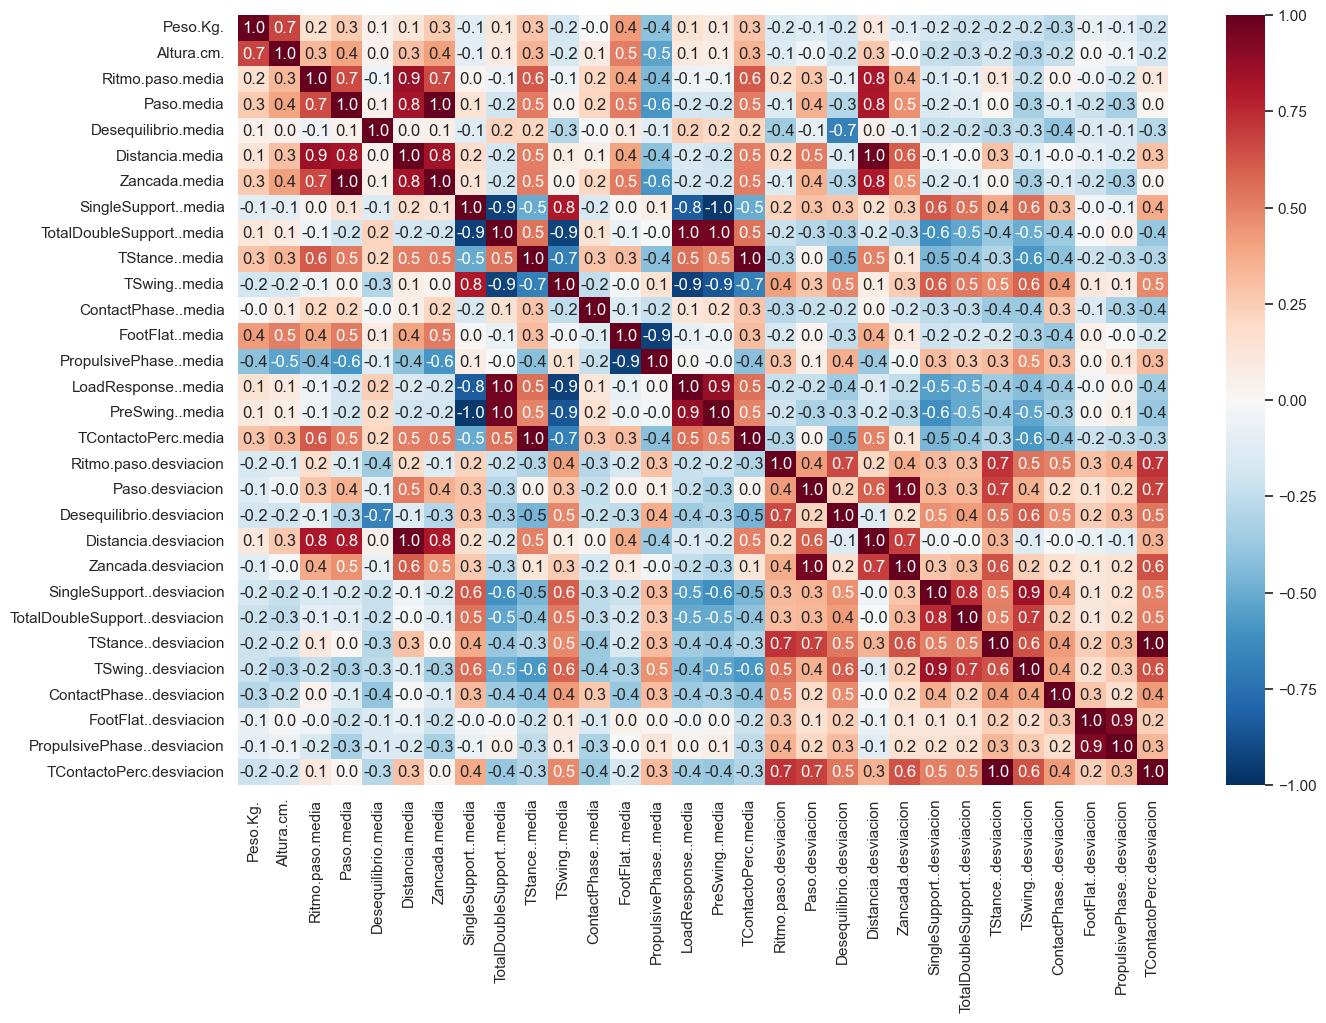

In [43]:
corr_mat = df[THR.get_feature_names_out()].corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat, annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1)
plt.savefig("varThresholdCorr.png")

#### Recursive feature elimination (REF)

In [44]:
REF = DecisionTreeClassifier()
REF = RFE(REF, n_features_to_select=30, step=1)
REF = REF.fit(x, y.values.ravel())
REF.get_feature_names_out()

array(['Peso.Kg.', 'Altura.cm.', 'N.Pie', 'TContacto.media',
       'Ritmo.paso.media', 'Paso.media', 'Velocidad.media',
       'Aceleracion.media', 'Desequilibrio.media', 'Distancia.media',
       'StrideTime.Cycle.media', 'TotalDoubleSupport..media',
       'TSwing.media', 'TSwing..media', 'ContactPhase..media',
       'FootFlat.media', 'PropulsivePhase..media',
       'Ritmo.paso.desviacion', 'Paso.desviacion',
       'Desequilibrio.desviacion', 'StrideTime.Cycle.desviacion',
       'SingleSupport.desviacion', 'SingleSupport..desviacion',
       'TotalDoubleSupport.desviacion', 'TotalDoubleSupport..desviacion',
       'TStance.desviacion', 'TSwing.desviacion', 'TSwing..desviacion',
       'FootFlat.desviacion', 'FootFlat..desviacion'], dtype=object)

In [45]:
REF

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=30)

#### Sequential Feature Selector (SFS)

In [46]:
NeuralN = MLPClassifier(max_iter=1000, early_stopping=True, activation = 'tanh',solver='sgd', alpha=1, hidden_layer_sizes=(10, 5), random_state=1)
sfs = SequentialFeatureSelector(NeuralN, n_features_to_select=30, direction='forward')
sfs.fit(x, y.values.ravel())

SequentialFeatureSelector(estimator=MLPClassifier(activation='tanh', alpha=1,
                                                  early_stopping=True,
                                                  hidden_layer_sizes=(10, 5),
                                                  max_iter=1000, random_state=1,
                                                  solver='sgd'),
                          n_features_to_select=30)

In [47]:
#FUNCION PARA VER LA INTERSECCIÓN (INNER JOIN; CUALES COINCIDEN) DE LAS VARIABLES ELEGIDAS POR LOS DIFERENTES MÉTODOS DE SELECCION DE VARIABLES
def comparing(array1, array2, array3):
    variables=[]
    for x in array1:
        if (x in array2):
            if (x in array3):
                variables.append(x)
    return variables

comparing(THR.get_feature_names_out(),sfs.get_feature_names_out(),THR.get_feature_names_out())
# comparing(sfs.get_feature_names_out(),THR.get_feature_names_out())
# comparing(REF.get_feature_names_out(),THR.get_feature_names_out())

['Peso.Kg.',
 'Altura.cm.',
 'Ritmo.paso.media',
 'Paso.media',
 'Desequilibrio.media',
 'Distancia.media',
 'Zancada.media',
 'SingleSupport..media',
 'TotalDoubleSupport..media',
 'TStance..media',
 'TSwing..media',
 'ContactPhase..media',
 'PropulsivePhase..media',
 'PreSwing..media',
 'TContactoPerc.media',
 'Distancia.desviacion',
 'Zancada.desviacion',
 'ContactPhase..desviacion']

##### Aplico balanceo de clases y estandarizacion a los conjuntos que hemos reducido variables con SFS o REF

In [48]:
oversample = SMOTE(sampling_strategy=0.7)
undersample = RandomUnderSampler(sampling_strategy=0.85)
scaler=StandardScaler()

In [49]:
X_SFS_resampled, y_SFS_resampled = oversample.fit_resample(x[sfs.get_feature_names_out()], y)
y_SFS_resampled.value_counts()

# Random Under sampler
X_SFS_resampled, y_SFS_resampled = undersample.fit_resample(X_SFS_resampled, y_SFS_resampled)
y_SFS_resampled.value_counts()

scaler.fit(X_SFS_resampled) # calculo la media para poder hacer la transformacion
X_SFS_resampled_scaled=scaler.transform(X_SFS_resampled)# Ahora si, escalo los datos y los normalizo

In [50]:
X_REF_resampled, y_REF_resampled = oversample.fit_resample(x[REF.get_feature_names_out()], y)

# Random Under sampler
X_REF_resampled, y_REF_resampled = undersample.fit_resample(X_REF_resampled, y_REF_resampled)

scaler.fit(X_REF_resampled) # calculo la media para poder hacer la transformacion
X_REF_resampled_scaled=scaler.transform(X_REF_resampled)# Ahora si, escalo los datos y los normalizo

In [51]:
def preprocesser(x,y):
    oversample = SMOTE(sampling_strategy=0.7)
    undersample = RandomUnderSampler(sampling_strategy=0.85)
    scaler=StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7)
    X_train_REF_resampled, y_train_REF_resampled = oversample.fit_resample(X_train[REF.get_feature_names_out()], y_train)
    X_train_REF_resampled, y_train_REF_resampled = undersample.fit_resample(X_train_REF_resampled, y_train_REF_resampled)
    scaler.fit(X_train_REF_resampled) # calculo la media para poder hacer la transformacion
    X_train_REF_resampled_scaled=scaler.transform(X_train_REF_resampled)# Ahora si, escalo los datos y los normalizo
    X_test_scaled=scaler.transform(X_test[REF.get_feature_names_out()])
    return (X_train_REF_resampled_scaled,X_test_scaled,y_train_REF_resampled,y_test)

### SVC con PCA

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7)
pipe = Pipeline([
    ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=30, step=1)), # Feature Selection
    ('sc', StandardScaler()), # StandardScaler
    ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
    ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
    ('SVC', SVC(kernel='linear')) #SVC
])

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_macro'].mean())
print("Recall:", cv_results['test_recall_macro'].mean())
print("F1 Score:", cv_results['test_f1_macro'].mean())
print("Roc_auc:", cv_results['test_roc_auc'].mean())
print()

Accuracy: 0.6510734463276836
Precision: 0.6160174003755424
Recall: 0.6311664503199654
F1 Score: 0.61393036470045
Roc_auc: 0.6603550363234725



#### Hiperparametrización

Fitting 3 folds for each of 100 candidates, totalling 300 fits


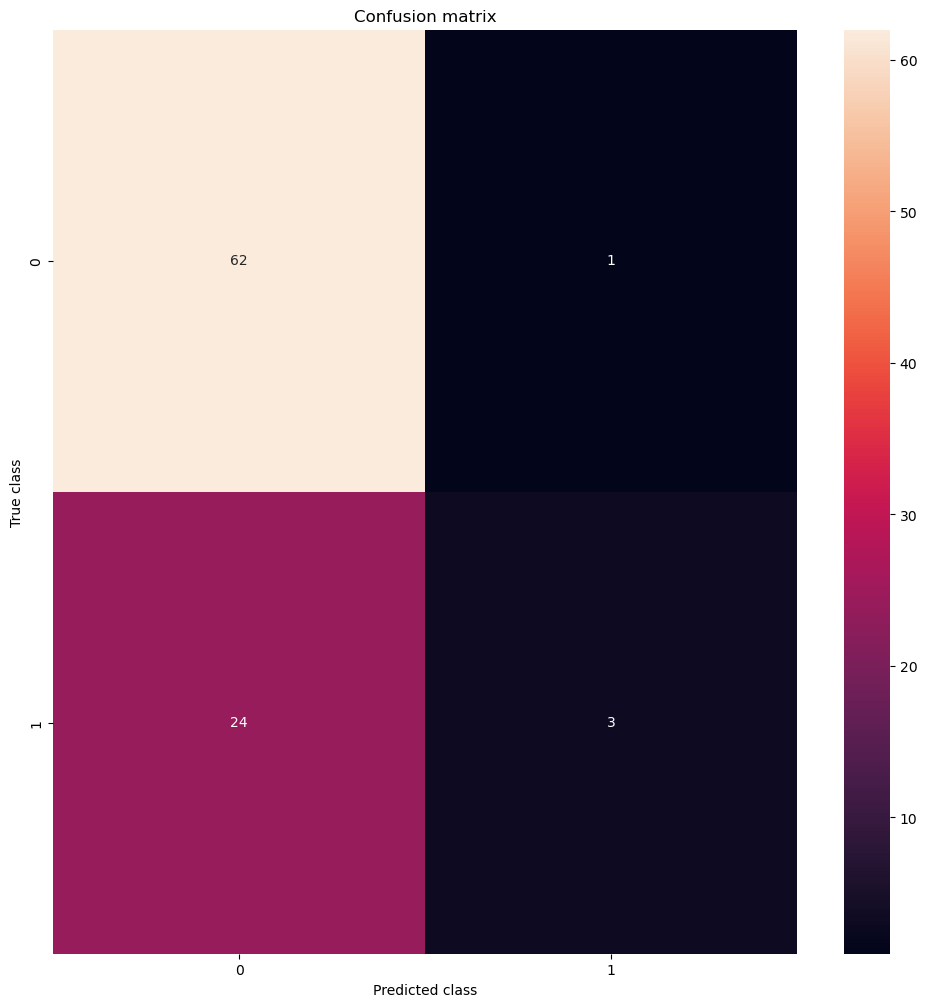

              precision    recall  f1-score   support

           0       0.72      0.98      0.83        63
           1       0.75      0.11      0.19        27

    accuracy                           0.72        90
   macro avg       0.74      0.55      0.51        90
weighted avg       0.73      0.72      0.64        90



In [139]:
C = [ 0.5, 1, 5, 10, 15, 30, 50]
kernel = ["linear","poly","rbf", "sigmoid"]
degree = [3,5,10,15]
gamma=['scale','auto']

pipe = Pipeline([
    ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=30, step=1)), # Feature Selection
    ('sc', StandardScaler()), # StandardScaler
    ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
    ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
    ('SVC', SVC(kernel='linear')) #SVC
])

param_dist = {'SVC__C': C,
               'SVC__kernel': kernel,
               'SVC__degree': degree,
               'SVC__gamma': gamma,
             }

# Se ejecutará 100 veces por el nº de cross validations
rs = RandomizedSearchCV(pipe, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(X_train,y_train.values.ravel())
svc_model=rs.best_estimator_
pred_y = svc_model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [137]:
rs.best_params_

{'SVC__kernel': 'rbf', 'SVC__gamma': 'auto', 'SVC__degree': 10, 'SVC__C': 0.5}

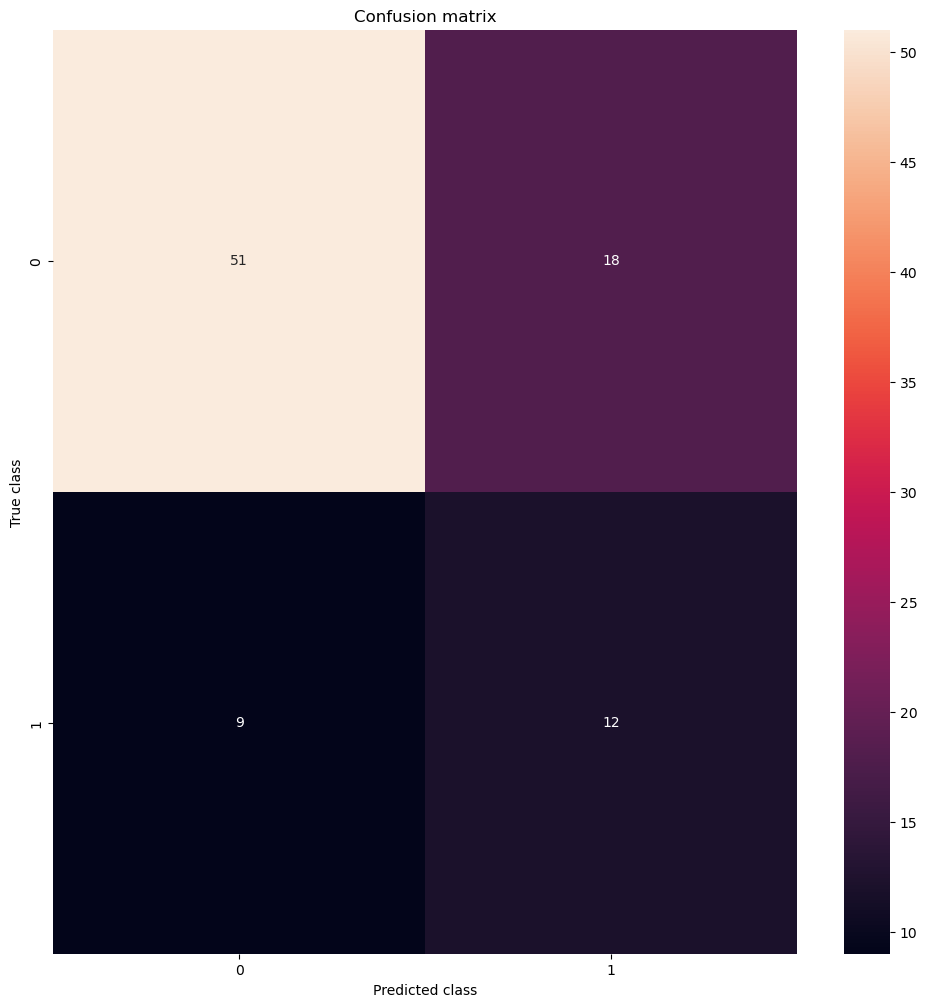

              precision    recall  f1-score   support

           0       0.85      0.74      0.79        69
           1       0.40      0.57      0.47        21

    accuracy                           0.70        90
   macro avg       0.62      0.66      0.63        90
weighted avg       0.74      0.70      0.72        90



In [21]:
oversample = SMOTE(sampling_strategy=0.7)
undersample = RandomUnderSampler(sampling_strategy=0.85)
scaler=StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7)
X_train_REF_resampled, y_train_REF_resampled = oversample.fit_resample(X_train[REF.get_feature_names_out()], y_train)
X_train_REF_resampled, y_train_REF_resampled = undersample.fit_resample(X_train_REF_resampled, y_train_REF_resampled)
scaler.fit(X_train_REF_resampled) # calculo la media para poder hacer la transformacion
X_train_REF_resampled_scaled=scaler.transform(X_train_REF_resampled)# Ahora si, escalo los datos y los normalizo
X_test_scaled=scaler.transform(X_test[REF.get_feature_names_out()])
model = run_model(X_train_REF_resampled_scaled, X_test_scaled, y_train_REF_resampled, y_test, SVC, kernel='linear', probability=True)
#Los parámetros al final con **args
pred_y = model.predict(X_test_scaled)
mostrar_resultados(y_test, pred_y) #SVC

In [22]:
REF.get_feature_names_out()

array(['Peso.Kg.', 'Altura.cm.', 'N.Pie', 'TContacto.media',
       'TPaso.media', 'Ritmo.paso.media', 'Velocidad.media',
       'Aceleracion.media', 'Distancia.media', 'Zancada.media',
       'TotalDoubleSupport..media', 'TStance.media', 'TStance..media',
       'ContactPhase.media', 'ContactPhase..media', 'FootFlat.media',
       'PropulsivePhase..media', 'Ritmo.paso.desviacion',
       'Paso.desviacion', 'Desequilibrio.desviacion',
       'Zancada.desviacion', 'StrideTime.Cycle.desviacion',
       'SingleSupport.desviacion', 'SingleSupport..desviacion',
       'TotalDoubleSupport..desviacion', 'TStance.desviacion',
       'TSwing..desviacion', 'ContactPhase.desviacion',
       'FootFlat..desviacion', 'LoadResponse.desviacion'], dtype=object)

In [23]:
joblib.dump(model, 'modelo_entrenado.pkl')
joblib.dump(scaler,'scaler.pkl')
joblib.dump(REF,'REF.pkl')

['REF.pkl']

### Redes Neuronales y PCA

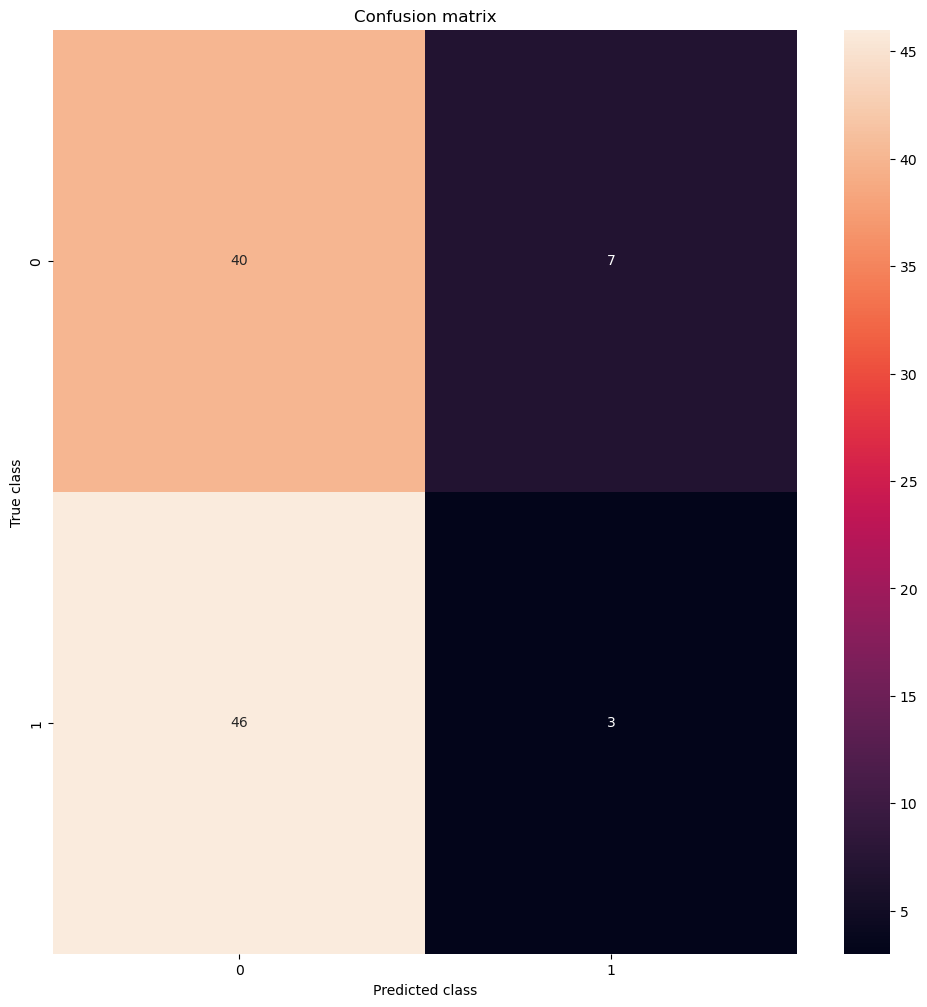

              precision    recall  f1-score   support

           1       0.47      0.85      0.60        47
           2       0.30      0.06      0.10        49

    accuracy                           0.45        96
   macro avg       0.38      0.46      0.35        96
weighted avg       0.38      0.45      0.35        96



In [254]:
X_train, X_test, y_train, y_test = train_test_split(X_REF_resampled_scaled, y_resampled, train_size=0.7,random_state=42)
model = run_model(X_train, X_test, y_train, y_test, MLPClassifier, max_iter=1000, early_stopping=True, activation = 'tanh',solver='sgd', alpha=1, hidden_layer_sizes=(10, 5), random_state=1)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

#### Hiperparametrización

In [47]:
hidden_layer_sizes=[(1, 3),(1, 4),(1, 5),(1, 10),(2, 3),(2, 5),(2, 10),(2, 20),(2, 50),(3, 3),
                    (3, 5),(3, 10),(3, 15),(3, 20),(4, 5),(4,7),(4, 10),(4, 20),(4, 25),(5, 5),(5, 7),
                   (5, 10),(6, 10),(7, 5),(7, 10),(8, 5),(9, 10),(9, 20),(10, 5),(10, 10),(10, 50),
                   ]
activation =["tanh","logistic","relu"]
solver = ["lbfgs","sgd","adam"]
alpha = [0.00001,0.0001,0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]
learning_rate = ["constant","adaptive"]
learning_rate_init = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20]
max_iter = [1000,2000]
early_stopping=[True]

pipe = Pipeline([
    ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=30, step=1)), # Feature Selection
    ('sc', StandardScaler()), # StandardScaler
    ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
    ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
    ('NN', MLPClassifier()) #Neural Networks
])

param_dist = {'NN__hidden_layer_sizes': hidden_layer_sizes,
               'NN__activation': activation,
               'NN__solver': solver,
               'NN__alpha': alpha,
               'NN__learning_rate': learning_rate,
               'NN__learning_rate_init': learning_rate_init,
               'NN__max_iter': max_iter,
               'NN__early_stopping': early_stopping }

# Se ejecutará 100 veces por el nº de cross validations
rs = RandomizedSearchCV(pipe, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


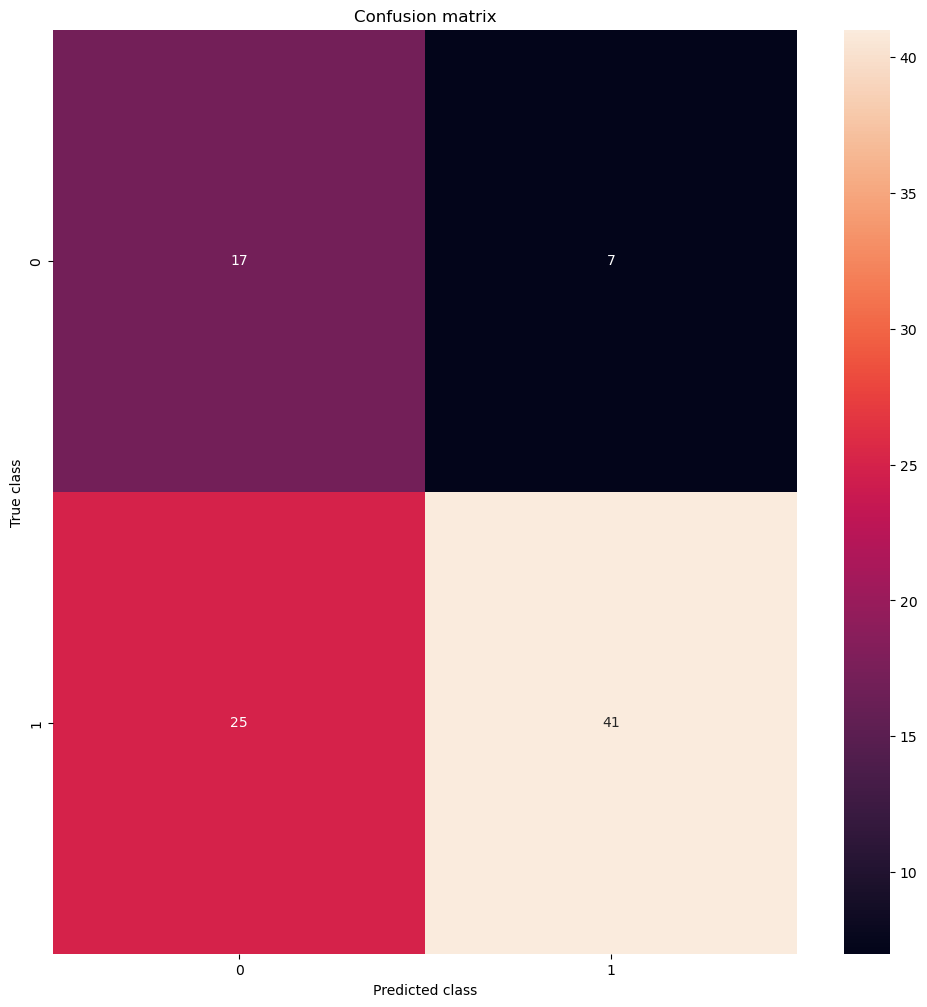

              precision    recall  f1-score   support

           1       0.40      0.71      0.52        24
           2       0.85      0.62      0.72        66

    accuracy                           0.64        90
   macro avg       0.63      0.66      0.62        90
weighted avg       0.73      0.64      0.66        90



In [49]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7,random_state=42)
rs.fit(X_train,y_train.values.ravel())
nn_model=rs.best_estimator_
pred_y = nn_model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [50]:
rs.best_params_

{'NN__solver': 'lbfgs',
 'NN__max_iter': 1000,
 'NN__learning_rate_init': 0.1,
 'NN__learning_rate': 'adaptive',
 'NN__hidden_layer_sizes': (2, 10),
 'NN__early_stopping': True,
 'NN__alpha': 10,
 'NN__activation': 'relu'}

In [52]:
pipe = Pipeline([
    ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=30, step=1)), # Feature Selection
    ('sc', StandardScaler()), # StandardScaler
    ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
    ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
    ('NN', MLPClassifier(solver='lbfgs',max_iter=1000,learning_rate_init = 0.1, learning_rate='adaptive',hidden_layer_sizes=(2,10), early_stopping = True, alpha=10,activation='relu')) #Neural Networks
])

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_macro'].mean())
print("Recall:", cv_results['test_recall_macro'].mean())
print("F1 Score:", cv_results['test_f1_macro'].mean())
print("Roc_auc:", cv_results['test_roc_auc'].mean())
print()

C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6745762711864407
Precision: 0.5688321105167249
Recall: 0.6063526223497531
F1 Score: 0.5805315186144966
Roc_auc: 0.6205571117335824



### Nearest Neighbors

In [63]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7)
pipe = Pipeline([
    ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=10, step=1)), # Feature Selection
    ('sc', StandardScaler()), # StandardScaler
    ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
    ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
    ('KNN', KNeighborsClassifier(7)) #KNN
])

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_macro'].mean())
print("Recall:", cv_results['test_recall_macro'].mean())
print("F1 Score:", cv_results['test_f1_macro'].mean())
print("Roc_auc:", cv_results['test_roc_auc'].mean())
print()

Accuracy: 0.6009039548022599
Precision: 0.5646468871468872
Recall: 0.5733460864020404
F1 Score: 0.5616315113924769
Roc_auc: 0.6463752438644834



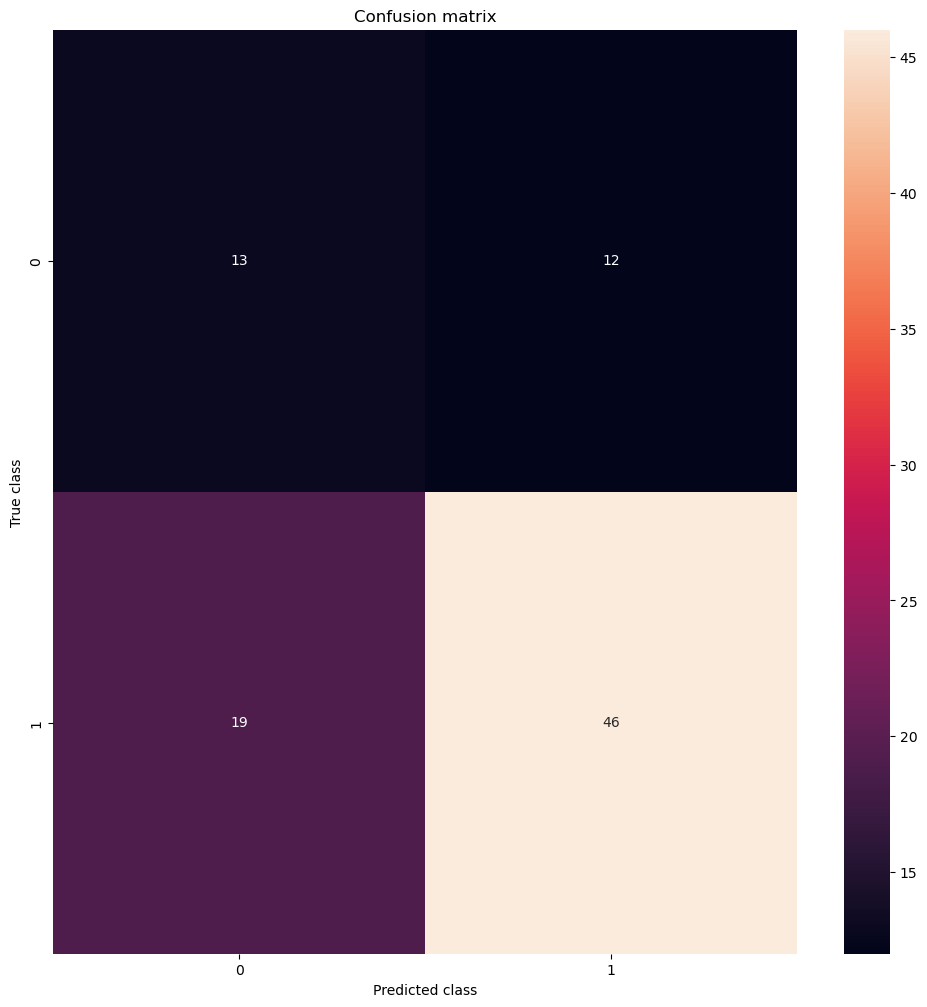

              precision    recall  f1-score   support

           1       0.41      0.52      0.46        25
           2       0.79      0.71      0.75        65

    accuracy                           0.66        90
   macro avg       0.60      0.61      0.60        90
weighted avg       0.69      0.66      0.67        90



In [67]:
X_train, X_test, y_train, y_test = preprocesser(x,y)
# X_train, X_test, y_train, y_test = train_test_split(X_REF_resampled_scaled, y_REF_resampled, train_size=0.7)
model = run_model(X_train, X_test, y_train, y_test, KNeighborsClassifier, 7)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Gaussian Process Classifier

gaussian process classifier es lo que mejor resultado da. Independientemente que método de feature selection usemos da un resultado de entre 0.65 y 0.71 aprox

In [94]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7)
pipe = Pipeline([
    ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=10, step=1)), # Feature Selection
    ('sc', StandardScaler()), # StandardScaler
    ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
    ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
    ('GPC', GaussianProcessClassifier()) #GPC
])

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_macro'].mean())
print("Recall:", cv_results['test_recall_macro'].mean())
print("F1 Score:", cv_results['test_f1_macro'].mean())
print("Roc_auc:", cv_results['test_roc_auc'].mean())
print()

Accuracy: 0.6440677966101696
Precision: 0.5910726052016283
Recall: 0.6000273280043725
F1 Score: 0.5922866957401187
Roc_auc: 0.6452498614622001



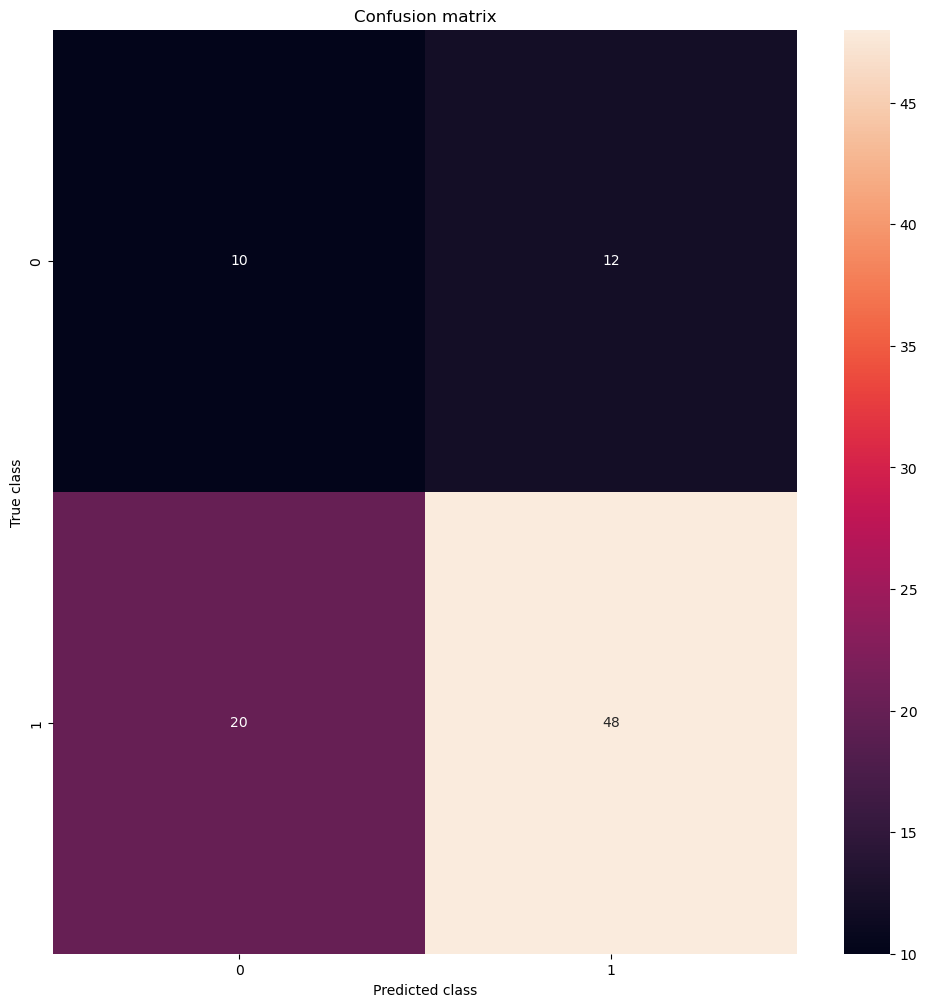

              precision    recall  f1-score   support

           1       0.33      0.45      0.38        22
           2       0.80      0.71      0.75        68

    accuracy                           0.64        90
   macro avg       0.57      0.58      0.57        90
weighted avg       0.69      0.64      0.66        90



In [75]:
X_train, X_test, y_train, y_test = preprocesser(x,y)
# X_train, X_test, y_train, y_test = train_test_split(X_REF_resampled_scaled, y_REF_resampled, train_size=0.7)
Gauss_model = run_model(X_train, X_test, y_train, y_test, GaussianProcessClassifier)
pred_y = Gauss_model.predict(X_test)
mostrar_resultados(y_test, pred_y)

##### Comparación del modelo dependiendo del nº de variables seleccionadas

In [13]:
str(sfs.get_feature_names_out())

"['Peso.Kg.' 'Altura.cm.' 'N.Pie' 'TContacto.media' 'TPaso.media'\n 'Ritmo.paso.media' 'Paso.media' 'Velocidad.media' 'Aceleracion.media'\n 'Desequilibrio.media' 'Distancia.media' 'Zancada.media'\n 'StrideTime.Cycle.media' 'SingleSupport.media' 'SingleSupport..media'\n 'TotalDoubleSupport.media' 'TotalDoubleSupport..media' 'TStance.media'\n 'TStance..media' 'TSwing.media' 'TSwing..media' 'ContactPhase..media'\n 'PropulsivePhase..media' 'PreSwing..media' 'TContactoPerc.media'\n 'TContacto.desviacion' 'TPaso.desviacion' 'Distancia.desviacion'\n 'Zancada.desviacion' 'ContactPhase..desviacion']"

In [81]:
# Creating a loop for comparing this model with different features number depending on performance values


# Define different numbers of features to try
num_features_list = [1,2,3,4,10,20,30,40,50,60]

REF = DecisionTreeClassifier()

for num_features in num_features_list:
    pipe = Pipeline([
        ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=num_features, step=1)), # Feature Selection
        ('sc', StandardScaler()), # StandardScaler
        ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
        ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
        ('GPC', GaussianProcessClassifier()) #GPC
    ])

    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
    print(num_features)
    print("Accuracy:", cv_results['test_accuracy'].mean())
    print("Precision:", cv_results['test_precision_macro'].mean())
    print("Recall:", cv_results['test_recall_macro'].mean())
    print("F1 Score:", cv_results['test_f1_macro'].mean())
    print("Roc_auc:", cv_results['test_roc_auc'].mean())
    print()

1
Accuracy: 0.6069491525423729
Precision: 0.5606929834871012
Recall: 0.5682573842545148
F1 Score: 0.5587241858937013
Roc_auc: 0.5808305435995538

2
Accuracy: 0.6072316384180791
Precision: 0.510746877236239
Recall: 0.5124228553209902
F1 Score: 0.5051940251728906
Roc_auc: 0.5666575573318757

3
Accuracy: 0.6307909604519775
Precision: 0.5809089426368839
Recall: 0.5907141718476009
F1 Score: 0.5805463242652011
Roc_auc: 0.6403137406724208

4
Accuracy: 0.6543502824858756
Precision: 0.6058685431982994
Recall: 0.6075914918813055
F1 Score: 0.6005243557145906
Roc_auc: 0.673522959319229

10
Accuracy: 0.6607909604519774
Precision: 0.601232700376906
Recall: 0.6056409555692197
F1 Score: 0.601909688421028
Roc_auc: 0.6395652569971078

20
Accuracy: 0.6307344632768362
Precision: 0.580528357593575
Recall: 0.5813645783516659
F1 Score: 0.5782201606488291
Roc_auc: 0.6111130088891925

30
Accuracy: 0.6104519774011299
Precision: 0.5646815075168734
Recall: 0.5696943818177678
F1 Score: 0.5593421597838064
Roc_auc: 

#### Guardo el Modelo

In [14]:
joblib.dump(Gauss_model, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

In [15]:
model_prueba = joblib.load('modelo_entrenado.pkl') # Carga del modelo.
scaler =joblib.load('scaler.pkl')

In [20]:
pred1=pd.read_csv("pred1.csv", sep=";", header=0, decimal=',')
pred1=pred1.drop(['Unnamed: 0', 'ApellidosyNombre'],axis=1)
pred1=pred1.rename(columns={"Ritmo.paso.m..media":"Ritmo.paso.media","Ritmo.paso.m..desviacion":"Ritmo.paso.desviacion"})

In [21]:
sample_scaled=scaler.transform(pred1)
  
# Aplico PCA
# sample_pca = pca.transform(sample_scaled)
predicion = model_prueba.predict_proba(X_train[1].reshape(1,-1))

In [22]:
predicion

array([[0.5576592, 0.4423408]])

### Pipeline para Gaussian, inutil, pero queda como ejemplo de pipeline

### Decision Tree

In [83]:
    pipe = Pipeline([
        ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=num_features, step=1)), # Feature Selection
        ('sc', StandardScaler()), # StandardScaler
        ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
        ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
        ('DTC', DecisionTreeClassifier(max_depth=25)) #DTC
    ])

    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
    print(num_features)
    print("Accuracy:", cv_results['test_accuracy'].mean())
    print("Precision:", cv_results['test_precision_macro'].mean())
    print("Recall:", cv_results['test_recall_macro'].mean())
    print("F1 Score:", cv_results['test_f1_macro'].mean())
    print("Roc_auc:", cv_results['test_roc_auc'].mean())
    print()

60
Accuracy: 0.5773446327683616
Precision: 0.5445897268522081
Recall: 0.5460374393659904
F1 Score: 0.533059396339172
Roc_auc: 0.5460374393659904



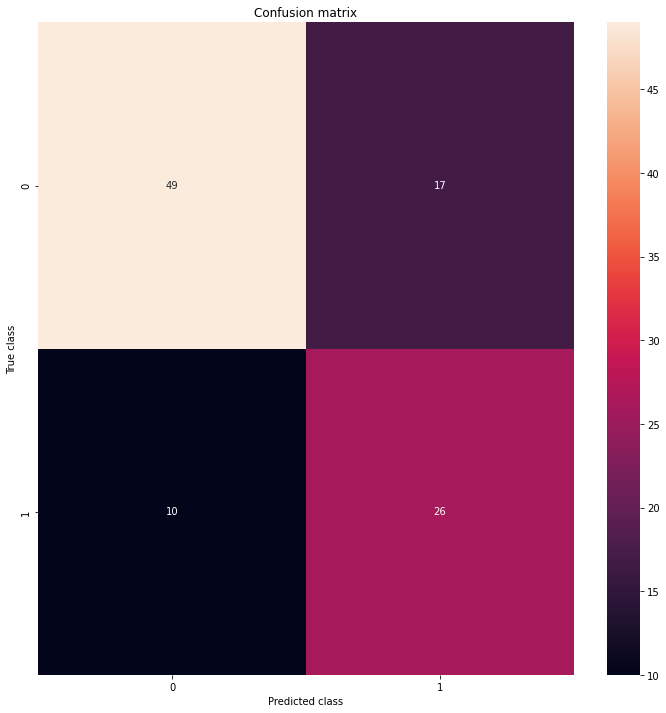

              precision    recall  f1-score   support

           0       0.83      0.74      0.78        66
           1       0.60      0.72      0.66        36

    accuracy                           0.74       102
   macro avg       0.72      0.73      0.72       102
weighted avg       0.75      0.74      0.74       102



In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled_pca, y_resampled, train_size=0.7)
model = run_model(X_train, X_test, y_train, y_test, DecisionTreeClassifier, max_depth=25)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.7)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Random Forest

In [86]:
    pipe = Pipeline([
        ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=num_features, step=1)), # Feature Selection
        ('sc', StandardScaler()), # StandardScaler
        ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
        ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
        ('RFC', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)) #RFC
    ])

    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
    print("Accuracy:", cv_results['test_accuracy'].mean())
    print("Precision:", cv_results['test_precision_macro'].mean())
    print("Recall:", cv_results['test_recall_macro'].mean())
    print("F1 Score:", cv_results['test_f1_macro'].mean())
    print("Roc_auc:", cv_results['test_roc_auc'].mean())
    print()

Accuracy: 0.6209604519774011
Precision: 0.5419962137420418
Recall: 0.538763635535515
F1 Score: 0.5382873410308481
Roc_auc: 0.5559149947241769



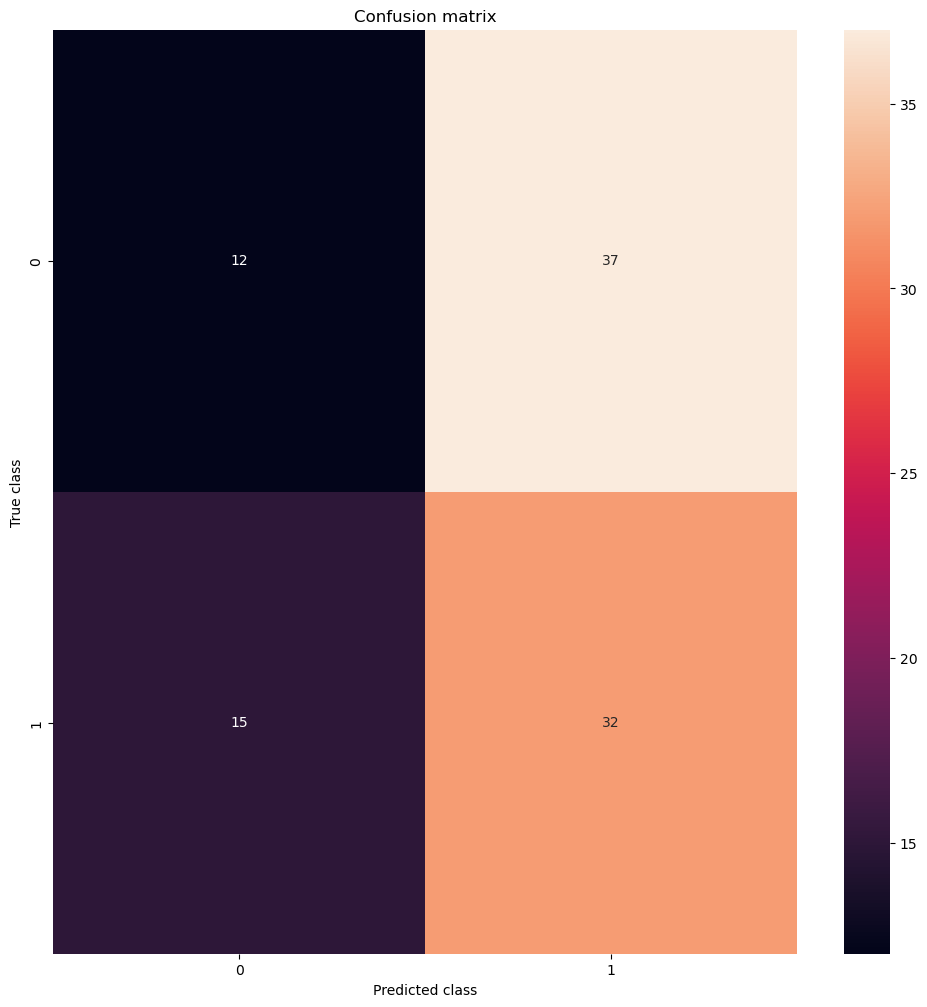

              precision    recall  f1-score   support

           1       0.44      0.24      0.32        49
           2       0.46      0.68      0.55        47

    accuracy                           0.46        96
   macro avg       0.45      0.46      0.43        96
weighted avg       0.45      0.46      0.43        96



In [217]:
X_train, X_test, y_train, y_test = train_test_split(X_REF_resampled_scaled, y_resampled, train_size=0.7)
model = run_model(X_train, X_test, y_train, y_test, RandomForestClassifier, max_depth=5, n_estimators=10, max_features=1)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### AdaBoost

In [88]:
    pipe = Pipeline([
        ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=num_features, step=1)), # Feature Selection
        ('sc', StandardScaler()), # StandardScaler
        ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
        ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
        ('ADAB', AdaBoostClassifier()) #ADAB
    ])

    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
    print("Accuracy:", cv_results['test_accuracy'].mean())
    print("Precision:", cv_results['test_precision_macro'].mean())
    print("Recall:", cv_results['test_recall_macro'].mean())
    print("F1 Score:", cv_results['test_f1_macro'].mean())
    print("Roc_auc:", cv_results['test_roc_auc'].mean())
    print()

Accuracy: 0.6540112994350282
Precision: 0.6090780179133838
Recall: 0.6135774635057276
F1 Score: 0.6065297738812317
Roc_auc: 0.645115119218419



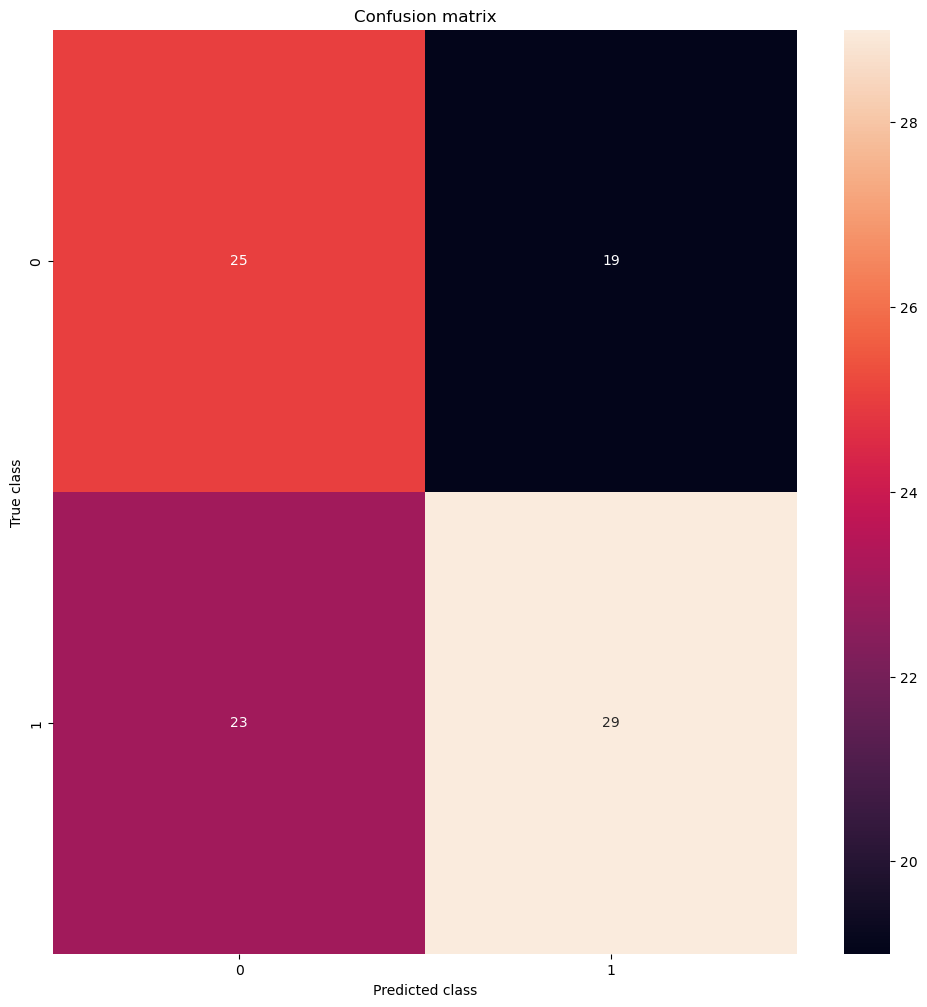

              precision    recall  f1-score   support

           1       0.52      0.57      0.54        44
           2       0.60      0.56      0.58        52

    accuracy                           0.56        96
   macro avg       0.56      0.56      0.56        96
weighted avg       0.57      0.56      0.56        96



In [221]:
X_train, X_test, y_train, y_test = train_test_split(X_REF_resampled_scaled, y_resampled, train_size=0.7)
model = run_model(X_train, X_test, y_train, y_test, AdaBoostClassifier)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Naive Bayes

In [89]:
    pipe = Pipeline([
        ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=num_features, step=1)), # Feature Selection
        ('sc', StandardScaler()), # StandardScaler
        ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
        ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
        ('GNB', GaussianNB()) #GNB
    ])

    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
    print("Accuracy:", cv_results['test_accuracy'].mean())
    print("Precision:", cv_results['test_precision_macro'].mean())
    print("Recall:", cv_results['test_recall_macro'].mean())
    print("F1 Score:", cv_results['test_f1_macro'].mean())
    print("Roc_auc:", cv_results['test_roc_auc'].mean())
    print()

Accuracy: 0.4971751412429378
Precision: 0.5135207749766574
Recall: 0.5169866320511944
F1 Score: 0.4668748566451958
Roc_auc: 0.5803672959698785



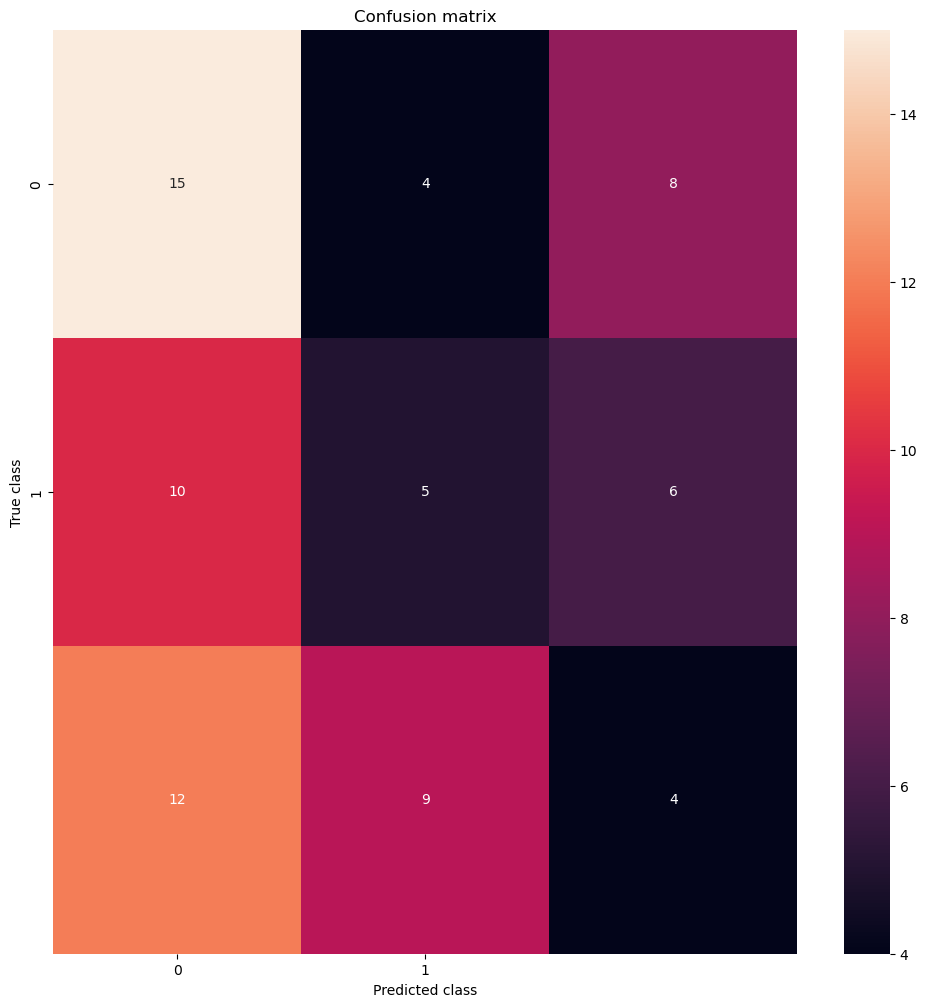

              precision    recall  f1-score   support

           1       0.41      0.56      0.47        27
           2       0.28      0.24      0.26        21
           3       0.22      0.16      0.19        25

    accuracy                           0.33        73
   macro avg       0.30      0.32      0.30        73
weighted avg       0.31      0.33      0.31        73



In [21]:
X_train, X_test, y_train, y_test = train_test_split(x[sfs.get_feature_names_out()], y, train_size=0.7)
model = run_model(X_train, X_test, y_train, y_test, GaussianNB)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### QDA

In [90]:
    pipe = Pipeline([
        ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=num_features, step=1)), # Feature Selection
        ('sc', StandardScaler()), # StandardScaler
        ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
        ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
        ('QDA', QuadraticDiscriminantAnalysis()) #QDA
    ])

    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
    print("Accuracy:", cv_results['test_accuracy'].mean())
    print("Precision:", cv_results['test_precision_macro'].mean())
    print("Recall:", cv_results['test_recall_macro'].mean())
    print("F1 Score:", cv_results['test_f1_macro'].mean())
    print("Roc_auc:", cv_results['test_roc_auc'].mean())
    print()

QuadraticDiscriminantAnalysis()

C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.6746892655367231
Precision: 0.5728647613991279
Recall: 0.5287820819384664
F1 Score: 0.5123727322215672
Roc_auc: 0.5409487372184646



C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


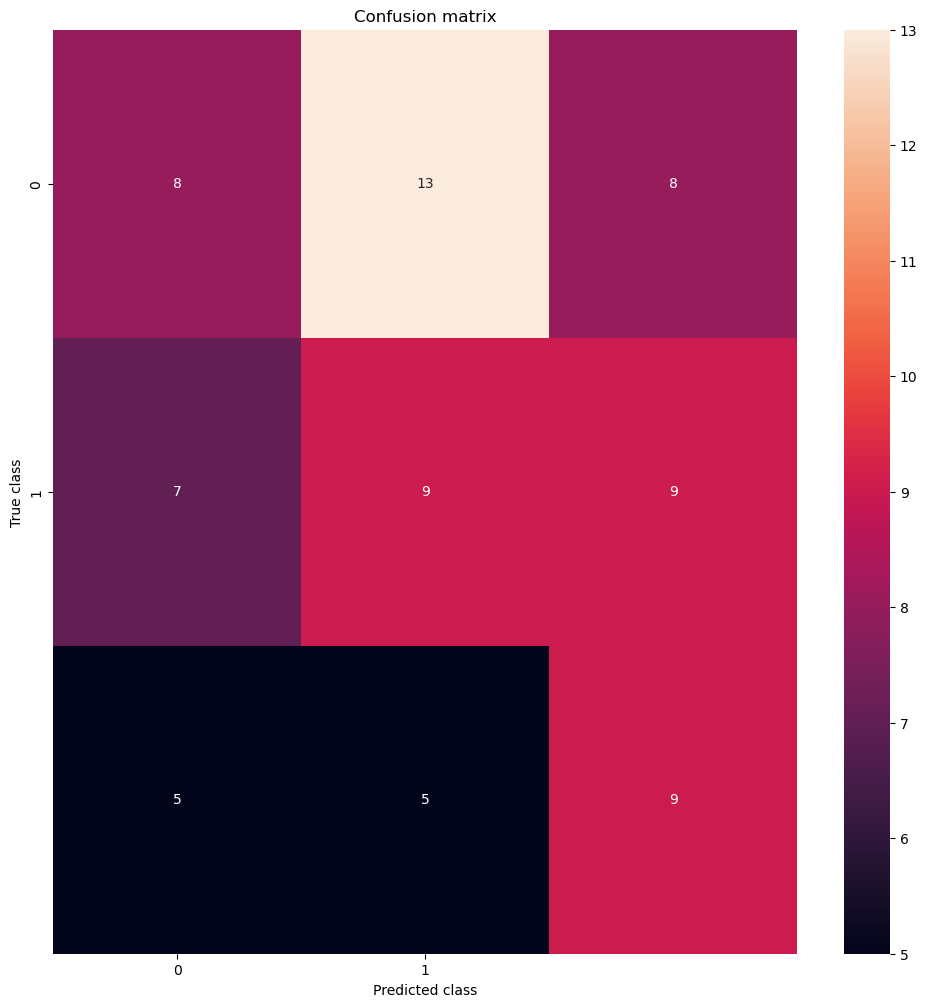

              precision    recall  f1-score   support

           1       0.40      0.28      0.33        29
           2       0.33      0.36      0.35        25
           3       0.35      0.47      0.40        19

    accuracy                           0.36        73
   macro avg       0.36      0.37      0.36        73
weighted avg       0.36      0.36      0.35        73



In [25]:
X_train, X_test, y_train, y_test = train_test_split(x[sfs.get_feature_names_out()], y, train_size=0.7)
model = run_model(X_train, X_test, y_train, y_test, QuadraticDiscriminantAnalysis)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Logistic Regression

In [93]:
    pipe = Pipeline([
        ('RFE',RFE(DecisionTreeClassifier(), n_features_to_select=num_features, step=1)), # Feature Selection
        ('sc', StandardScaler()), # StandardScaler
        ('ROS', SMOTE(sampling_strategy=0.7)), # Oversampler
        ('RUS', RandomUnderSampler(sampling_strategy=0.85)), # Undersampler 
        ('LR', LogisticRegression(multi_class="ovr",max_iter=10000)) #LR
    ])

    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']
    cv_results = cross_validate(pipe, x, y.values.ravel(), scoring=scoring_metrics, cv=5)
    # Print the results for the current number of features
    print("Accuracy:", cv_results['test_accuracy'].mean())
    print("Precision:", cv_results['test_precision_macro'].mean())
    print("Recall:", cv_results['test_recall_macro'].mean())
    print("F1 Score:", cv_results['test_f1_macro'].mean())
    print("Roc_auc:", cv_results['test_roc_auc'].mean())
    print()

Accuracy: 0.6610734463276836
Precision: 0.6123768013473896
Recall: 0.6193197604244951
F1 Score: 0.6133948315363655
Roc_auc: 0.6695418004600214



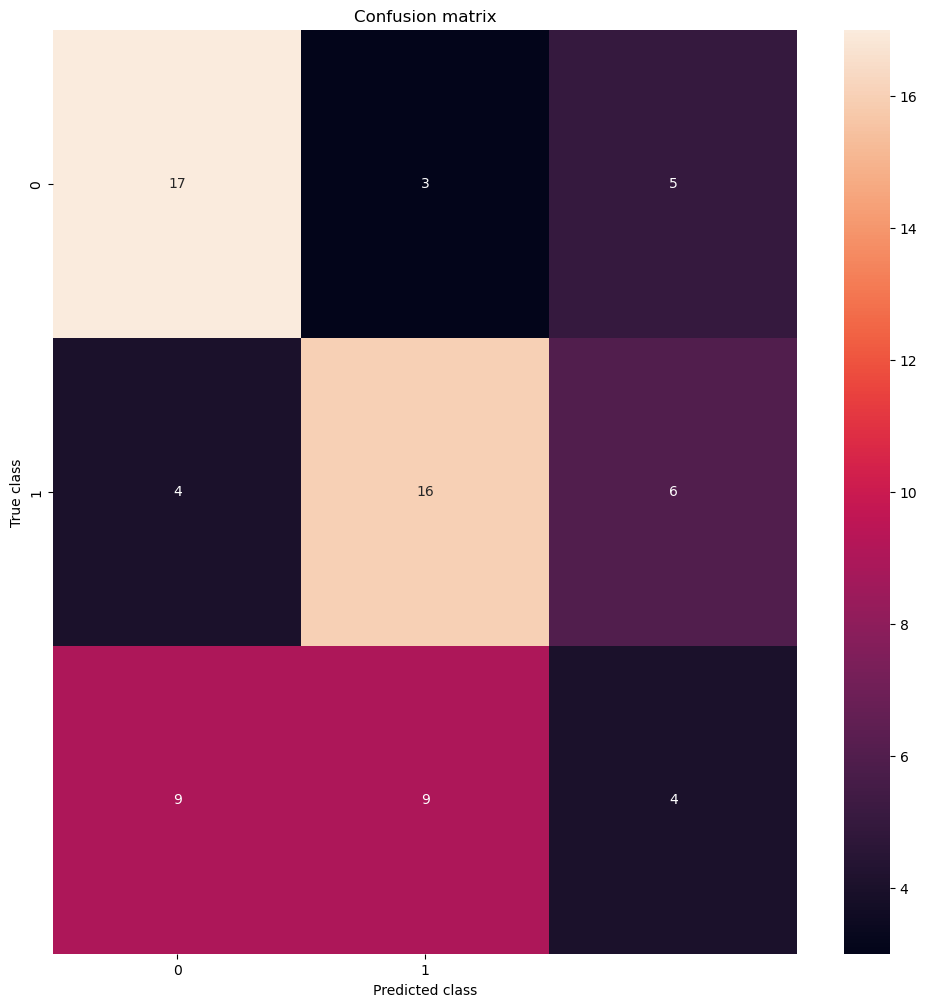

              precision    recall  f1-score   support

           1       0.57      0.68      0.62        25
           2       0.57      0.62      0.59        26
           3       0.27      0.18      0.22        22

    accuracy                           0.51        73
   macro avg       0.47      0.49      0.48        73
weighted avg       0.48      0.51      0.49        73



In [27]:
X_train, X_test, y_train, y_test = train_test_split(x[sfs.get_feature_names_out()], y, train_size=0.7)
model = run_model(X_train, X_test, y_train, y_test, LogisticRegression, multi_class="ovr",max_iter=10000)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Linear Regression

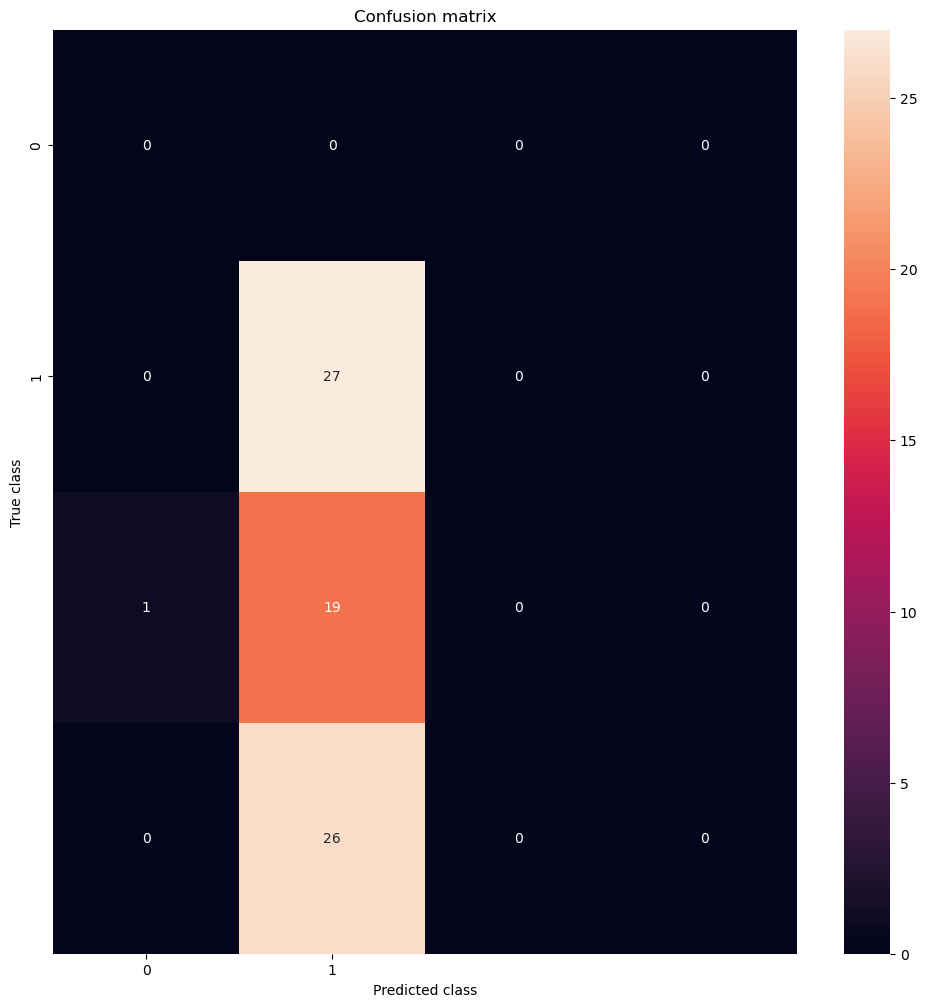

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.38      1.00      0.55        27
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        26

    accuracy                           0.37        73
   macro avg       0.09      0.25      0.14        73
weighted avg       0.14      0.37      0.20        73



C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Carlos\anaconda3\lib\site-packages\sklearn\metrics\

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x[sfs.get_feature_names_out()], y, train_size=0.7,random_state=42)
model = run_model(X_train, X_test, y_train, y_test, LinearRegression)
pred_y = model.predict(X_test)
## Multiclase
# pred_y[ (pred_y<2)] = 1
# pred_y[(2<=pred_y) & (pred_y<3.5)] = 3
# pred_y[pred_y>=3.5] = 4

## Binario
pred_y[ (pred_y<0.5)] = 0
pred_y[pred_y>=0.5] = 1
pred_y
mostrar_resultados(y_test, pred_y)